In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import pandas as pd

In [28]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [30]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [31]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [32]:
station = Base.classes.station

measurement = Base.classes.measurement

In [33]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [34]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

inspector.get_table_names()

['measurement', 'station']

In [35]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [36]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

2016-08-23


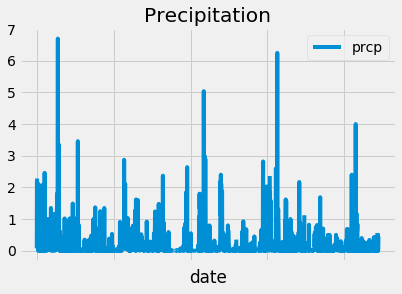

In [37]:
#retrieve last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

# Design a query to retrieve the last 12 months of precipitation data and plot the results
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

rain_df = pd.DataFrame(rain)
rain_df.dropna()
rain_df = rain_df.set_index('date')

#sort by date
rain_df = rain_df.sort_index(ascending=True)

#plot with pandas
rain_df.plot(title="Precipitation")

![precipitation](Images/precipitation.png)

In [38]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [39]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Station).count()
print(f"Station Count: {stations_count}")

Station Count: 9


In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [43]:
station_ID = active_station[0][0]

#query for station name
station_name = (session.query(station.name)
                      .filter_by(station = station_ID))
station_name = station_name[0][0]
print(f'{station_ID}: {station_name}')

USC00519281: WAIHEE 837.5, HI US


In [44]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
highest = (session.query(measurement.tobs)
                      .filter(measurement.station == station_ID)
                      .order_by(measurement.tobs.desc())
                      .first())
highest = highest[0]
print(highest)


lowest = (session.query(measurement.tobs)
                      .filter(measurement.station == station_ID)
                      .order_by(measurement.tobs.asc())
                      .first())
lowest = lowest[0]
print(lowest)

average = (session.query(func.avg(measurement.tobs))
                  .filter(measurement.station == station_ID))
average = average[0]
print(average)

85.0
54.0
(71.66378066378067,)


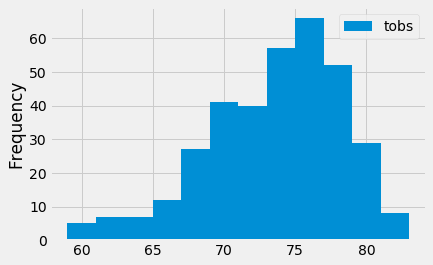

In [45]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = (session.query(measurement.date, measurement.tobs)
       .filter(measurement.date > last_year)
       .filter(measurement.station == station_ID)
       .order_by(measurement.date)
       .all())

tempTable = pd.DataFrame(temp)
tempTable = tempTable.set_index('date')

tempTable = tempTable.sort_index(ascending=True)

#histogram plot with pandas
tempTable.plot(kind='hist', bins=12)

In [46]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

print(calc_temps('2012-12-01', '2012-12-06'))

[(64.0, 72.08695652173913, 79.0)]


In [47]:
trip = '2019-12-01 to \n 2019-12-06'
tripStartDate = '2016-12-01'
tripEndDate = '2016-12-06'

tripTemps = calc_temps(tripStartDate, tripEndDate)

tripTemps

[(67.0, 71.48717948717949, 77.0)]

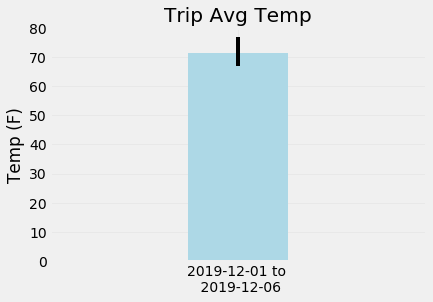

In [48]:
minTripTemp = tripTemps[0][0]
avgTripTemp = tripTemps[0][1]
maxTripTemp = tripTemps[0][2]

minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp

errorBars = np.array([[minError], [maxError]])

plt.bar(trip, avgTripTemp, yerr=errorBars, color = 'lightblue')
plt.ylim(0, 80)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.2)

In [49]:
sel = ([station.station, 
        station.name, 
        func.sum(measurement.prcp), 
        station.latitude, 
        station.longitude, 
        station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(station.station == measurement.station)
                   .filter(measurement.date >= tripStartDate)
                   .filter(measurement.date <= tripEndDate)
                   .group_by(station.station)
                   .order_by(func.sum(measurement.prcp).desc())
                   .all())

#convert query object to data frame
stationRainTable = pd.DataFrame(np.array(stationRain))

stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stationRainTable

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",5.52,21.3331,-157.803,152.4
1,USC00519281,"WAIHEE 837.5, HI US",1.75,21.4517,-157.849,32.9
2,USC00513117,"KANEOHE 838.1, HI US",1.13,21.4234,-157.802,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.96,21.3356,-157.711,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.93,21.5213,-157.837,7
5,USC00519397,"WAIKIKI 717.2, HI US",0.63,21.2716,-157.817,3
6,USC00517948,"PEARL CITY, HI US",None,21.3934,-157.975,11.9


![precipitation](Images/station-histogram.png)

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
